In [52]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import qiskit.extensions.quantum_initializer as qeqi
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
from skopt import gp_minimize

import sys
sys.path.append("..")

import Entangler
import TensorNetwork
import hamiltonians
import TNOptimize
import uuid
import json
import utils

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

In [53]:
n_qubits = 10
depth = 4
q, c = QuantumRegister(n_qubits), ClassicalRegister(n_qubits)
ent = Entangler.IsingEntangler()
TN = TensorNetwork.Checkerboard(q, c, ent, depth=depth)
# TN_UCC = TensorNetwork.UCCSD(q, c)

tol = 1e-6
method = "L-BFGS-B"
sv_b = Aer.get_backend("statevector_simulator")
qasm_b = Aer.get_backend("qasm_simulator")
unitary_b = Aer.get_backend('unitary_simulator')

### Prepare the exact data

Solve the problem explicitly and then dump that into the datafile. All states to the left of the infinite phase transition point get labeled as "0", those to the right get labeled as "1"

### Repack this into a pandas

In [54]:
# df_train = pd.read_csv("train.csv", header=None)
# df_test = pd.read_csv("test.csv", header=None)

# df_train = df_train.applymap(lambda x: np.complex(x))
# df_test = df_test.applymap(lambda x: np.complex(x))

# n_max = 2**n_qubits

# df_train[n_max] = df_train[n_max].apply(lambda x: x.real)
# df_train[n_max+1] = df_train[n_max+1].apply(lambda x: x.real)
# df_train[n_max+2] = df_train[n_max+2].apply(lambda x: x.real)

# df_test[n_max] = df_test[n_max].apply(lambda x: x.real)
# df_test[n_max+1] = df_test[n_max+1].apply(lambda x: x.real)
# df_test[n_max+2] = df_test[n_max+2].apply(lambda x: x.real)


# df_vqe = pd.read_csv("6_qubits_vqe.csv", header=None)
# #df_vqe = df_test.applymap(lambda x: np.complex(x))


# n_qubits = 10

filename = "vqe_data.csv"

n_max = 2**n_qubits + 100
n_cdata = 2**n_qubits
df_vqe_2 = pd.read_csv(filename, header=None)
df_vqe_2 = df_vqe_2.applymap(lambda x: np.complex(x))

df_vqe_2[n_max] = df_vqe_2[n_max].apply(lambda x: x.real)
df_vqe_2[n_max+1] = df_vqe_2[n_max+1].apply(lambda x: x.real)
df_vqe_2[n_max+2] = df_vqe_2[n_max+2].apply(lambda x: x.real)

# df_vqe = df_vqe_2.drop([0, 1])
df_vqe = df_vqe_2

In [55]:
df_vqe_clean = df_vqe.sort_values(by=[n_max])
df_vqe_clean.index = np.arange(len(df_vqe))
# df_vqe_clean = df_vqe.sort_index(by=[n_max])

todrop = []
tokeep = []
for i in range(len(df_vqe) // 2):
    E_1 = df_vqe_clean.iloc[i * 2, n_max + 1]
    E_2 = df_vqe_clean.iloc[i * 2 + 1, n_max + 1]
    h_1 = df_vqe_clean.iloc[i * 2, n_max]
    h_2 = df_vqe_clean.iloc[i * 2 + 1, n_max]
#     print(h_1, h_2)
#     print(E_1, E_2)
#     print("====")
    if (E_2 > E_1):
        todrop.append(i * 2 + 1)
        tokeep.append(i * 2)
    else:
        todrop.append(i * 2)
        tokeep.append(i * 2 + 1)

        
for i in range(len(df_vqe) // 2):
    E_kept = df_vqe_clean.iloc[tokeep[i], n_max + 1]
    E_dropped = df_vqe_clean.iloc[todrop[i], n_max + 1]
    if E_dropped < E_kept:
        print("AAA")

print(df_vqe_clean.iloc[:20, [n_max, n_max + 1]])

print(todrop[:10])
print(tokeep[:10])

print("=============")        
        
df_vqe_clean = df_vqe_clean.drop(todrop)
print(df_vqe_clean.iloc[:10, [n_max, n_max + 1]])


    1124       1125
0   0.00  -5.999715
1   0.00  -9.999909
2   0.02 -10.000913
3   0.02  -6.061791
4   0.04 -10.003871
5   0.04 -10.003916
6   0.06 -10.008791
7   0.06 -10.008921
8   0.08 -10.015930
9   0.08 -10.015659
10  0.10 -10.024944
11  0.10 -10.024477
12  0.12 -10.035967
13  0.12 -10.035251
14  0.14 -10.048999
15  0.14 -10.048934
16  0.16 -10.064041
17  0.16 -10.063904
18  0.18 -10.080847
19  0.18 -10.080978
[0, 3, 4, 6, 9, 11, 13, 15, 17, 18]
[1, 2, 5, 7, 8, 10, 12, 14, 16, 19]
    1124       1125
1   0.00  -9.999909
2   0.02 -10.000913
5   0.04 -10.003916
7   0.06 -10.008921
8   0.08 -10.015930
10  0.10 -10.024944
12  0.12 -10.035967
14  0.14 -10.048999
16  0.16 -10.064041
19  0.18 -10.080978


In [56]:
h_list = np.array(df_vqe_clean[1124])
E_list = np.array(df_vqe_clean[1125])

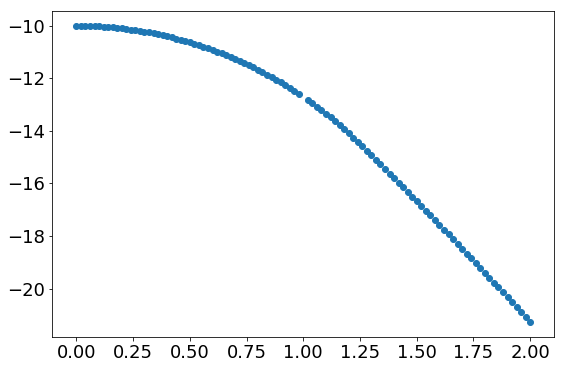

In [57]:
# %matplotlib inline
plt.scatter(h_list, E_list)

In [58]:
len(df_vqe_clean)

100

In [59]:
train_pos = int(0.8 * len(df_vqe_clean))

### Shuffle the dataset, split into train and test

In [60]:
df_vqe = df_vqe_clean.sample(frac=1).reset_index(drop=True)

In [61]:
train_pos = int(0.8 * len(df_vqe_clean))
df_train = df_vqe.iloc[:train_pos,:]
df_test = df_vqe.iloc[train_pos:,:]

In [62]:
current_state = np.array(df_train.iloc[0][:n_cdata])

#### Transform VQE dataset into a collection on complex rows (use only for that crappy dataset with 6 qubits)

In [63]:
measure_circ = QuantumCircuit(q, c)
for i in range(n_qubits):
    measure_circ.measure(q[i], c[i])

###   Construct loss functions and prediction functions

Slowdown is NOT in the counting procedure (well of course it isn't)

In [64]:
def prediction(state, q, c, NN_circ, shots=10000, mode="qasm"):
    """Probability of being in class II"""
    circ = QuantumCircuit(q, c)
    IG = qeqi.InitializeGate(state, q, circ)
    IG.reapply(circ)
    circ += NN_circ
    # 
    label = 0
    
    if mode == "qasm":
        circ += measure_circ    
        job = execute(circ, qasm_b, shots=shots)
        result = job.result()
        answer = result.get_counts()  
        for key, value in answer.items():
            if key.count("1") > key.count("0"):
                label += value
            elif key.count("1") == key.count("0"):
                label += value / 2
        label = label / shots
    elif mode == "statevector":
        job = execute(circ, sv_b)
        result = job.result()
        res_state = result.get_statevector(circ)
        for i in range(len(res_state)):
            qty_ones = bin(i).count("1")
            if qty_ones > len(q) // 2:
                label += abs(res_state[i])**2
            elif qty_ones == len(q) // 2:
                label += abs(res_state[i])**2 / 2 
    else:
        raise ValueError("Incorrect mode")

    #label = abs(res_state[-1])**2 / (abs(res_state[-1])**2 + abs(res_state[0])**2 + 1e-4)
    return label


def unitary_prediction(state, U):
    """Returns the probability that the state is in class II by
    transforming the circuit into a unitary map"""
#     if U_supply is None:
#         result = execute(NN_circ, unitary_b).result()
#         U = result.get_unitary(NN_circ)
#     else:
#         U = U_supply
    res_state = U @ state
    
    label = [0, 0]
    
    for i in range(len(res_state)):
        qty_ones = bin(i).count("1")
        if qty_ones > len(q) // 2:
            label[1] += abs(res_state[i])**2
        elif qty_ones < len(q) // 2:
            label[0] += abs(res_state[i])**2 / 2 

    return label[1] / (label[0] + label[1])


In [65]:
params = 2 * np.pi * np.random.rand(TN.n_params)
circ = TN.construct_circuit(params)

def build_loss_fun(df, start, batch_size, TN):
    """construct the loss function for a batch"""
#     if (finish <= start):
#         raise ValueError("Specify other rows")
    if batch_size < 1:
        raise ValueError("Invalid batch size")
    #indices = np.random.choice(len(df), batch_size, replace=False)
    #indices = np.arange(start, start + batch_size)
    
    def f(x):
        circ = TN.construct_circuit(x)
        result = execute(circ, unitary_b).result()
        U = result.get_unitary(circ)
        logloss = 0
        for i in range(start, start+batch_size):
            state = df_train.iloc[i][:n_cdata]
            y = df_train.iloc[i][n_max+2].real
            p = unitary_prediction(state, U)
            logloss += -(y * np.log(p) + (1 - y) * np.log(1 - p))
            
        return logloss / batch_size
    return f

In [66]:
f = build_loss_fun(df_train, 0, 80, TN)

In [67]:
%%time


NN_circ = TN.construct_circuit(np.ones(TN.n_params))
result = execute(NN_circ, unitary_b).result()
U = result.get_unitary(NN_circ)
#print(prediction(current_state, TN.q, TN.c, NN_circ, mode="qasm"))
print(unitary_prediction(current_state, U))

0.8968660169528987
CPU times: user 1.42 s, sys: 63.9 ms, total: 1.48 s
Wall time: 6.73 s


In [68]:
%%time
x = np.random.rand(TN.n_params)
print(f(x))

1.464813435817271
CPU times: user 2.22 s, sys: 533 ms, total: 2.75 s
Wall time: 6.85 s


The approach above is very costly because it has to rebuild the unitary map at every call of the function

In [41]:
def rand_grad(x, f, eps):
    dx = np.random.randn(np.shape(x)[0]) * eps
    f_plus = f(x + dx)
    f_minus = f(x - dx)
    return (f_plus - f_minus) / 2 / dx, 0.5 * (f_plus + f_minus)

In [42]:
rand_grad(x, f, 1e-4)

(array([ -0.4977686 ,   0.65501116,  -0.25828076,  -0.98814402,
          0.21112013,  -0.16436441,   0.8096258 ,   0.16072449,
          0.31116968,   0.2495324 ,  -0.26493939,   1.03532112,
          0.63356986,   0.17547448,  -0.50736852,   0.36162478,
          0.18860055,   0.35337245,  -0.47493939,   2.87337612,
         -0.54519872,  -0.19583692,   0.19741259,   2.46291989,
          0.21019737,   0.38747483,   0.14695679,  -0.34987955,
         -0.49721925,  -0.17277697,  -1.07184264,   1.38577282,
         -1.29944399,  -0.71619106,   0.23661621,  -0.18647092,
          1.58307488,   0.41833129,  -0.51241191,  -1.78691046,
          0.78565471,  -1.07167927,   0.75306803,   0.92380904,
         -0.8980597 ,  -1.47363062,  -0.40779389,  -1.54299963,
          1.35603674,   1.36397138,   1.22690532,   0.25848469,
          0.15035493,  -0.69786011,   0.71375368,  -2.02893294,
          1.99597354,   1.3172972 ,  -3.18849799,  -0.30418718,
         -0.20808383,  -0.30671958,   0.

### Run the machine learning

In [43]:
%%time
batch_size = 100
n_epochs = 100

losses = []


params = 2 * np.pi * np.random.rand(TN.n_params)
x = params

lr_base = 5

decay = 1e-3
factor = 1 - decay

eps_base = 1e-1

v = np.zeros(TN.n_params) #momentum

for epoch in range(n_epochs):
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    for batch_num in range(len(df_train) // batch_size):
        
        start = batch_size * batch_num
        f = build_loss_fun(df_train, start, batch_size, TN)
        #res = minimize(f, x, options={'maxiter':3}, method="L-BFGS-B")
        
        eps = eps_base / (1 + batch_num * (epoch + 1))**0.5
        lr = lr_base / (1 + batch_num * (epoch + 1))**0.5
        
        #grad = approx_fprime(x, f, eps)
        dx = np.random.randn(np.shape(x)[0]) * eps
        f_plus = f(x + dx)
        f_minus = f(x - dx)
        
        grad = (f_plus - f_minus) / 2 / np.linalg.norm(dx)
                                
        v = 0.9 * v - grad * lr * dx
        x = x + v        
        
        loss = (f_plus + f_minus) / 2
        if (epoch % 10 == 0):
            print('Epoch {0:d} batch {1:d}'.format(epoch, batch_num))
            print('loss:', loss)
        losses.append(loss)
        
#     if (epoch % 10 ==0):
#         lr = lr * factor
        #print('lr:', lr)
        #print(res.fun)
        #x = res.x

Epoch 0 batch 0
loss: 0.7866737158460292
Epoch 0 batch 1
loss: 0.735607765345698
Epoch 0 batch 2
loss: 0.7026965883628344
Epoch 0 batch 3
loss: 0.6840177959168507
Epoch 0 batch 4
loss: 0.6538310634674904
Epoch 0 batch 5
loss: 0.6272729360632388
Epoch 0 batch 6
loss: 0.6273199776794005
Epoch 0 batch 7
loss: 0.5820959970197201
Epoch 10 batch 0
loss: 0.42159101136782107
Epoch 10 batch 1
loss: 0.39153139971617623
Epoch 10 batch 2
loss: 0.362672642682001
Epoch 10 batch 3
loss: 0.39019873079501455
Epoch 10 batch 4
loss: 0.3948737358945152
Epoch 10 batch 5
loss: 0.40880118964433326
Epoch 10 batch 6
loss: 0.3671325504960484
Epoch 10 batch 7
loss: 0.4020152598698348
Epoch 20 batch 0
loss: 0.3889550949120374
Epoch 20 batch 1
loss: 0.2940735953824727
Epoch 20 batch 2
loss: 0.3177929203700658
Epoch 20 batch 3
loss: 0.35479683899826103
Epoch 20 batch 4
loss: 0.30521445116591883
Epoch 20 batch 5
loss: 0.31219782665714635
Epoch 20 batch 6
loss: 0.298845952380024
Epoch 20 batch 7
loss: 0.2858131491145

In [69]:
x = [ 7.88566885,  5.57262969,  3.31575204,  2.52260022,  4.63372683,
        2.03326717,  3.39884656,  0.58882239,  1.4371148 ,  6.31460732,
        2.75504802,  3.17318168,  4.55778403,  0.54570938,  5.07837665,
        1.90720252,  1.18228654,  3.34923554,  2.88419169,  3.18780128,
        2.80643765, -1.71457802,  1.16545145,  0.59748925,  3.15421318,
        8.64487332,  4.08296961,  0.63137071,  0.36625812,  6.09104975,
        3.00263684,  3.02392755,  5.20485907,  4.95652024,  2.99609563,
        3.56377492,  3.36279011,  2.79407486,  6.57538661,  2.25981725,
        1.02477799,  6.08961369, -0.2821432 ,  3.41720903,  5.4304107 ,
        3.26992855,  1.46236803,  6.0498095 ,  5.17873266,  3.50186565,
       -0.5531557 ,  4.51364667,  3.01422152, -0.28906655, -0.30621207,
        3.66101559,  0.71069141,  8.97657046,  3.6472432 ,  2.27180934,
        5.37926973,  2.76516709,  2.88793832,  5.09125684, -1.21820463,
        3.32294188,  2.79398114,  0.81419679,  1.45329901,  2.38058609,
        3.19739456, -0.21956584,  0.32115685, -1.20878963,  1.54552705,
        1.43747308,  2.49391183,  4.86681118,  1.68376976,  3.42766854,
        2.7322432 ,  1.34589925,  4.62928466, -0.21706109,  2.9911826 ,
        4.34784354,  0.87113722,  0.85075528,  1.5028714 ,  0.17363522,
       -1.8159517 ,  0.6754199 ,  1.21490509, 10.17935577, -3.00588571,
        0.19054222,  0.9136896 ,  1.00750769,  1.28624999, -1.85888703]

In [21]:
### 10 qubit SPSA

# array([ 7.88566885,  5.57262969,  3.31575204,  2.52260022,  4.63372683,
#         2.03326717,  3.39884656,  0.58882239,  1.4371148 ,  6.31460732,
#         2.75504802,  3.17318168,  4.55778403,  0.54570938,  5.07837665,
#         1.90720252,  1.18228654,  3.34923554,  2.88419169,  3.18780128,
#         2.80643765, -1.71457802,  1.16545145,  0.59748925,  3.15421318,
#         8.64487332,  4.08296961,  0.63137071,  0.36625812,  6.09104975,
#         3.00263684,  3.02392755,  5.20485907,  4.95652024,  2.99609563,
#         3.56377492,  3.36279011,  2.79407486,  6.57538661,  2.25981725,
#         1.02477799,  6.08961369, -0.2821432 ,  3.41720903,  5.4304107 ,
#         3.26992855,  1.46236803,  6.0498095 ,  5.17873266,  3.50186565,
#        -0.5531557 ,  4.51364667,  3.01422152, -0.28906655, -0.30621207,
#         3.66101559,  0.71069141,  8.97657046,  3.6472432 ,  2.27180934,
#         5.37926973,  2.76516709,  2.88793832,  5.09125684, -1.21820463,
#         3.32294188,  2.79398114,  0.81419679,  1.45329901,  2.38058609,
#         3.19739456, -0.21956584,  0.32115685, -1.20878963,  1.54552705,
#         1.43747308,  2.49391183,  4.86681118,  1.68376976,  3.42766854,
#         2.7322432 ,  1.34589925,  4.62928466, -0.21706109,  2.9911826 ,
#         4.34784354,  0.87113722,  0.85075528,  1.5028714 ,  0.17363522,
#        -1.8159517 ,  0.6754199 ,  1.21490509, 10.17935577, -3.00588571,
#         0.19054222,  0.9136896 ,  1.00750769,  1.28624999, -1.85888703])

array([ 7.88566885,  5.57262969,  3.31575204,  2.52260022,  4.63372683,
        2.03326717,  3.39884656,  0.58882239,  1.4371148 ,  6.31460732,
        2.75504802,  3.17318168,  4.55778403,  0.54570938,  5.07837665,
        1.90720252,  1.18228654,  3.34923554,  2.88419169,  3.18780128,
        2.80643765, -1.71457802,  1.16545145,  0.59748925,  3.15421318,
        8.64487332,  4.08296961,  0.63137071,  0.36625812,  6.09104975,
        3.00263684,  3.02392755,  5.20485907,  4.95652024,  2.99609563,
        3.56377492,  3.36279011,  2.79407486,  6.57538661,  2.25981725,
        1.02477799,  6.08961369, -0.2821432 ,  3.41720903,  5.4304107 ,
        3.26992855,  1.46236803,  6.0498095 ,  5.17873266,  3.50186565,
       -0.5531557 ,  4.51364667,  3.01422152, -0.28906655, -0.30621207,
        3.66101559,  0.71069141,  8.97657046,  3.6472432 ,  2.27180934,
        5.37926973,  2.76516709,  2.88793832,  5.09125684, -1.21820463,
        3.32294188,  2.79398114,  0.81419679,  1.45329901,  2.38

In [104]:
## XXZ, 10 qubit SPSA, 1000 points

# x = [ 0.59134174,  1.77833508,  6.15307727,  0.97224229,  5.18295461,
#         3.87446598,  2.54634569,  2.39160509,  4.22670151,  7.60375649,
#         4.43706293, -2.19028689,  2.83785361,  0.58476969,  3.91007783,
#         1.46608058,  3.75548438,  3.2050852 , -0.2324716 ,  4.20569331,
#         0.44747557, -0.05655545,  1.57631918,  1.65515135,  0.32314769,
#         6.18368274,  5.53437731,  5.45078031,  3.59205742,  4.14864355,
#         6.04624357,  2.63395642,  0.85160589,  2.37053693,  1.24301618,
#         2.08491361,  2.06525527,  1.07005622,  2.93735439,  6.61673426,
#         2.96551719,  2.70170338,  2.41211006,  4.86863224,  1.11162726,
#         5.97042287,  0.09910628,  5.84605866,  0.53470843,  2.15537269,
#         4.28163653,  5.98519454,  3.12286189,  5.83074693,  2.20164976,
#         4.44520995,  3.165546  ,  6.0415898 ,  5.35582743,  3.06468876,
#         4.48554246,  5.62580235,  4.46543988,  2.914892  ,  7.019866  ,
#        -0.14500223,  3.31575805,  1.60400157,  2.15646147,  5.9615348 ,
#         3.0546739 ,  5.82499504,  2.22488638,  1.70663956,  4.30644405,
#         6.64998163,  1.5827069 ,  5.66515041, -0.39784265,  0.63251041,
#        -0.14490925,  1.77787319,  5.83851547,  5.30889564,  3.67590437,
#         4.8743527 ,  2.07849864,  1.3314205 ,  1.06498805,  6.73240164,
#         5.39908099,  2.14184337,  1.39862086,  3.45140637,  4.63750996,
#         0.03935619,  0.45063615,  6.43629943,  4.65174439,  3.36627017]

### See on test data

In [70]:
len(x)

100

In [29]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})

In [73]:
#### here you can plot either both train and test data (df_vqe)
#### or only train/test data


NN_circ = TN.construct_circuit(np.array(x))
preds = []
trues = np.array(df_vqe[n_max + 2])
result = execute(NN_circ, unitary_b).result()
U = result.get_unitary(NN_circ)
for i in range(len(df_vqe)):
    state = df_vqe.iloc[i][:n_cdata]
    preds.append(unitary_prediction(state, U))

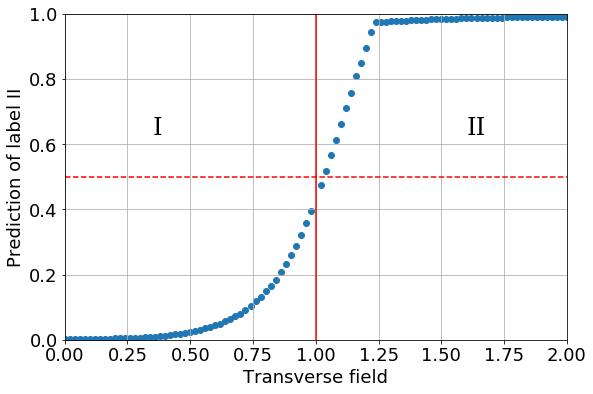

In [78]:
# %matplotlib inline
# plt.rcParams.update({'font.size': 14})


plt.figure()
fields = np.array(df_vqe[n_max])
plt.scatter(fields, preds)

plt.xlabel('Transverse field')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 2])
plt.plot([1, 1], [0, 1], 'r')
plt.text(0.35, 0.63, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.63, 'II', fontsize=24, fontfamily='serif')
plt.plot([0, 2], [0.5, 0.5], 'r--')
plt.show()

In [76]:
correct = 0
for i, p in enumerate(preds):
    if abs(trues[i] - p) < 0.5:
        correct += 1
print(correct / len(df_vqe))

0.99


In [108]:
plt.loglog(np.arange(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Log loss')

Text(0, 0.5, 'Log loss')

In [120]:
h_list = np.linspace(0, 2, num=81)

exact_preds = []

h_0 = hamiltonians.xxz_heisenberg_model(10, 1, 0)
h_1 = hamiltonians.xxz_heisenberg_model(10, 1, 1)
H_0 = hamiltonians.explicit_hamiltonian(h_0)
H_1 = hamiltonians.explicit_hamiltonian(h_1)

for h in h_list:
    w, v = SPLA.eigsh(H_0 + h * H_1, which="SA")
    exact_preds.append(unitary_prediction(v[:, 0], U))

In [121]:
plt.scatter(h_list, exact_preds)

In [142]:
w, v = SPLA.eigsh(H_0 + 3 * H_1, which="SA")


In [143]:
Z = np.diag([1, -1])
theta = 0.1
rotate = np.diag(np.exp(theta * 1j * np.array([1, -1])))
rotate

array([[0.99500417+0.09983342j, 0.        +0.j        ],
       [0.        +0.j        , 0.99500417-0.09983342j]])

In [144]:
from functools import reduce
tot_rot = reduce(np.kron, [rotate] * 10)

In [145]:
psi = tot_rot @ v[:, 0]

In [146]:
for i in range(20):
    psi = tot_rot @ psi
    print((psi.conj() @ (H_0 + 0.1 * H_1) @ psi).real)

-14.235303041071555
-14.235303041071564
-14.235303041071575
-14.235303041071582
-14.235303041071592
-14.235303041071603
-14.235303041071608
-14.235303041071617
-14.235303041071626
-14.235303041071637
-14.235303041071644
-14.235303041071653
-14.235303041071662
-14.23530304107167
-14.235303041071681
-14.235303041071688
-14.235303041071699
-14.235303041071706
-14.235303041071713
-14.235303041071724


In [131]:
w[0]

-14.666520060397568

In [ ]:
losses

### VQE data points

In [33]:
fields_vqe = []
preds_vqe = []
for i in range(len(df_vqe)):
    full_row = list(map(float, df_vqe.iloc[i][0].split()[:-1]))
    state_unjson = full_row[:128]
    state = [full_row[2 * i] + 1j * full_row[2* i + 1] for i in range(64)]
    fields_vqe.append(full_row[-2])
    preds_vqe.append(unitary_prediction(state, U))

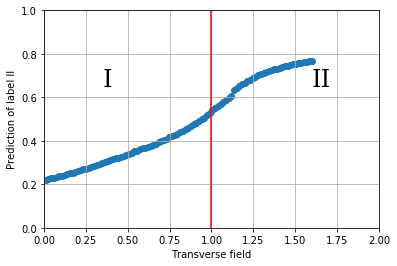

In [34]:
%matplotlib inline
plt.scatter(fields_vqe, preds_vqe)
plt.xlabel('Transverse field')
plt.ylabel('Prediction of label II')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 2])
plt.plot([1, 1], [0, 1], 'r')
#plt.plot([0, 2], [0.5, 0.5], 'r--')
plt.text(0.35, 0.65, 'I', fontsize=24, fontfamily='serif')
plt.text(1.6, 0.65, 'II', fontsize=24, fontfamily='serif')
plt.show()

CPU times: user 23.2 s, sys: 20.9 s, total: 44 s
Wall time: 40.2 s


In [ ]:
grad

In [ ]:
# #init params

# J = 1
# h_list = np.linspace(0.01, 1.6, num=100)
# #h_list = [1.4]

# start_vals = np.random.rand(TN.n_params) * 0.2

# with open('document.csv','a') as fd:

#     for h in h_list:
#         print('''
#         ------ h = {0:0.2f} -------
#         '''.format(h))

#         ham_dict = hamiltonians.ising_model(n_qubits, J, h)
#         H = hamiltonians.explicit_hamiltonian(ham_dict)
#         f = TNOptimize.build_objective_function(TN, explicit_H=H)


#         n_iters = 0
#         start_time = time.time()
#         res = minimize(f, start_vals, options={'maxiter': 300}, callback=None, 
#                        tol=tol, method=method)
#         time_spent = time.time() - start_time
#         print('Elapsed time: {0:5.2f}'.format(time_spent))

#         circ = TN.construct_circuit(res.x)
#         state = utils.get_state(circ)
#         print(res.fun)
#         print(res.nit)
#         print(res.message)

#         # Warm start
#         start_vals = res.x

#         jsonized = utils.jsonize(state)
#         flat = np.reshape(jsonized, (2**(n_qubits + 1), 1)).flatten()
#         data_row = np.concatenate((flat, res.x))
#         if h<0.5:
#             state_label = "L"
#         elif h>1.1:
#             state_label = "R"
#         else:
#             state_label = "nan"
#         extras = [h, res.fun]
#         total_data = np.concatenate((data_row, extras))
#         rowstring = np.array2string(total_data, max_line_width=5000)[2:-1]
#         rowstring = rowstring + ' ' + state_label + "\n"
#         fd.write(rowstring)
    

In [ ]:

    ##### trying to implement some basic SPSA
#         pert = 2 * c * np.random.rand(TN.n_params) - c
#         v1 = f(x + pert)
#         v2 = f(x - pert)
#         grad = (v1 - v2) / (2 * np.linalg.norm(pert))     

#         x = x - a * grad;

#         print(f(x))